In [1]:
# Name: Arooba Hanif
# Roll Number: Ezi-ML-B1-227
# Shift Time: Remote
# Internship Type: Hybird/Remote

# TASK 07

In [2]:
# Imports & Config
# Core
import numpy as np
import pandas as pd

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Model & Prep
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression


# Feature Selection
from sklearn.feature_selection import RFECV

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay
)

sns.set(style="whitegrid", font_scale=1.0)
plt.rcParams["figure.dpi"] = 120


In [3]:
# Load Dataset
# Try preprocessed CSV; else read the raw (your copy) and minimally clean
DATA_CANDIDATES = ["titanic_preprocessed.csv", "Titanic-Dataset - Copy.csv"]

df = None
for path in DATA_CANDIDATES:
    try:
        df = pd.read_csv(path)
        print(f"Loaded: {path}")
        break
    except Exception:
        pass

if df is None:
    raise FileNotFoundError(
        "CSV not found. Place 'titanic_preprocessed.csv' or 'Titanic-Dataset - Copy.csv' in the runtime."
    )

# Ensure Survived exists and is binary
assert "Survived" in df.columns, "Target column 'Survived' not found!"
df["Survived"] = df["Survived"].astype(int)

df.head()


Loaded: titanic_preprocessed.csv


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,3,1,-0.530377,1,0,-0.502445,0.059160,False,True,False,True,False,False
1,1,1,0,0.571831,1,0,0.786845,0.059160,False,False,False,False,True,False
2,1,3,0,-0.254825,0,0,-0.488854,-0.560975,False,True,True,False,False,False
3,1,1,0,0.365167,1,0,0.420730,0.059160,False,True,False,False,True,False
4,0,3,1,0.365167,0,0,-0.486337,-0.560975,False,True,False,True,False,False


In [4]:
# Select Features (X) & Target (y)
# Candidate columns that commonly exist
possible_numeric = ["Age", "SibSp", "Parch", "Fare", "FamilySize"]
possible_categoric = ["Pclass", "Sex", "Embarked", "Title", "Deck", "Cabin", "Ticket"]

numeric_cols = [c for c in possible_numeric if c in df.columns]
categoric_cols = [c for c in possible_categoric if c in df.columns]

# Always include Pclass if available (categorical treated as category)
if "Pclass" in categoric_cols and "Pclass" in numeric_cols:
    numeric_cols.remove("Pclass")  # ensure it stays in categorical

print("Numeric features:", numeric_cols)
print("Categorical features:", categoric_cols)

X = df[numeric_cols + categoric_cols].copy()
y = df["Survived"].copy()


Numeric features: ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']
Categorical features: ['Pclass', 'Sex']


In [8]:
# Preprocessing Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Define numeric and categorical columns
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
categoric_cols = df.select_dtypes(include=["object"]).columns

# Numeric pipeline
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Column transformer
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categoric_cols)
    ],
    remainder="drop"
)


In [9]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)


((712, 7),
 (179, 7),
 Survived
 0    0.616573
 1    0.383427
 Name: proportion, dtype: float64,
 Survived
 0    0.614525
 1    0.385475
 Name: proportion, dtype: float64)


 Baseline (All Features) Metrics:
Accuracy  : 0.8045
Precision : 0.7656
Recall    : 0.7101
F1        : 0.7368
ROC-AUC   : 0.8515


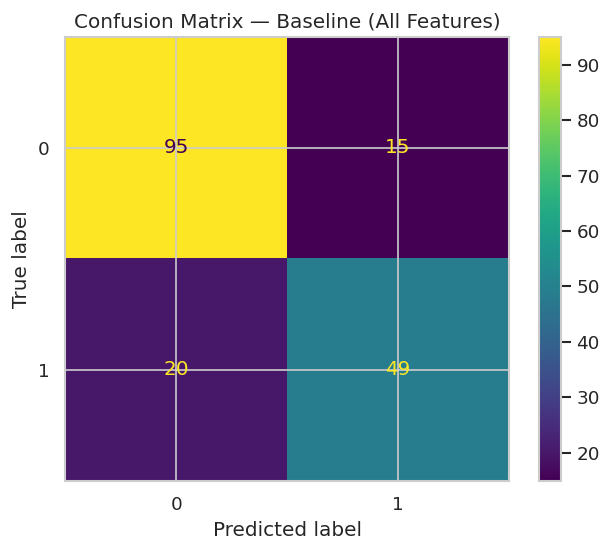

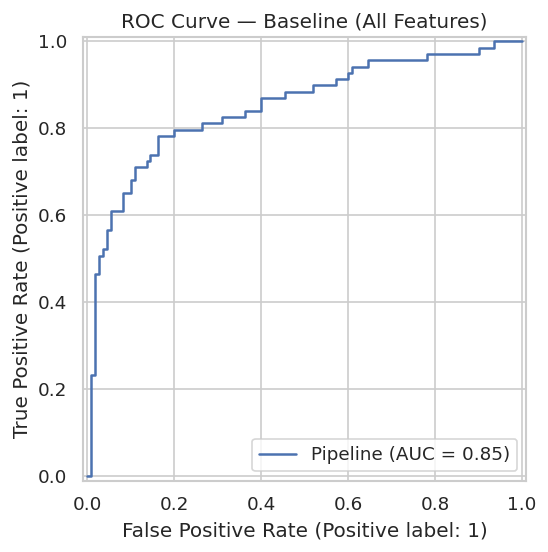

In [17]:
# Baseline Model (All Features)
# Baseline Logistic Regression pipeline
pipe_baseline = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000, solver="liblinear", random_state=42))
])

pipe_baseline.fit(X_train, y_train)

# Predictions
y_pred_base = pipe_baseline.predict(X_test)
y_proba_base = pipe_baseline.predict_proba(X_test)[:, 1]

# Evaluation Metrics
base_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_base),
    "Precision": precision_score(y_test, y_pred_base),
    "Recall": recall_score(y_test, y_pred_base),
    "F1": f1_score(y_test, y_pred_base),
    "ROC-AUC": roc_auc_score(y_test, y_proba_base),
}
print("\n Baseline (All Features) Metrics:")
for k, v in base_metrics.items():
    print(f"{k:10s}: {v:.4f}")

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_base)
plt.title("Confusion Matrix — Baseline (All Features)")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(pipe_baseline, X_test, y_test)
plt.title("ROC Curve — Baseline (All Features)")
plt.show()


In [26]:
# Make sure cols are list instead of pandas Index
numeric_cols = list(numeric_cols)
categoric_cols = list(categoric_cols)

# Get transformed feature names after ColumnTransformer
feature_names = []

# Numeric features (direct names)
if len(numeric_cols) > 0:
    feature_names.extend(numeric_cols)

# Categorical features (expanded after OneHotEncoder)
if len(categoric_cols) > 0:
    ohe = preprocess.named_transformers_["cat"]["ohe"]
    cat_feature_names = ohe.get_feature_names_out(categoric_cols)
    feature_names.extend(cat_feature_names)

print(" Transformed Feature Names:")
print(feature_names)

# 🔹 Prepare Arrays for RFE / RFECV
X_train_proc = prep_only.transform(X_train)
X_test_proc  = prep_only.transform(X_test)

print(" Shapes after transform:")
print("X_train_proc:", X_train_proc.shape)
print("X_test_proc :", X_test_proc.shape)


 Transformed Feature Names:
['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']
 Shapes after transform:
X_train_proc: (712, 7)
X_test_proc : (179, 7)


 Optimal number of features (RFECV): 3

 Selected Features by RFECV:
- Pclass
- Sex
- Age


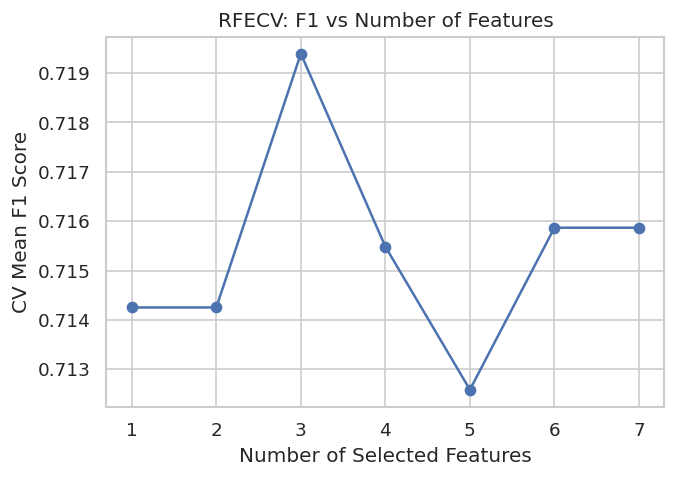

In [28]:
#  Cell 9 — RFECV (Recursive Feature Elimination with Cross-Validation)

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Estimator: Logistic Regression
logreg_for_rfe = LogisticRegression(max_iter=1000, solver="liblinear", random_state=42)

# 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rfecv = RFECV(
    estimator=logreg_for_rfe,
    step=1,
    cv=cv,
    scoring="f1",   # you can change to 'accuracy' if required
    n_jobs=-1
)

# Fit on transformed arrays
rfecv.fit(X_train_proc, y_train)

print(" Optimal number of features (RFECV):", rfecv.n_features_)

# Support mask + rankings
support_mask = rfecv.support_
ranking = rfecv.ranking_

# Selected feature names
selected_features = np.array(feature_names)[support_mask]
print("\n Selected Features by RFECV:")
for f in selected_features:
    print("-", f)

# 📈 Plot CV score vs number of features
plt.figure(figsize=(6,4))
plt.plot(
    range(1, len(rfecv.cv_results_['mean_test_score'])+1),
    rfecv.cv_results_['mean_test_score'],
    marker="o"
)
plt.xlabel("Number of Selected Features")
plt.ylabel("CV Mean F1 Score")
plt.title("RFECV: F1 vs Number of Features")
plt.grid(True)
plt.show()


RFE-Optimized Model Metrics:
Accuracy  : 0.7933
Precision : 0.7500
Recall    : 0.6957
F1        : 0.7218
ROC-AUC   : 0.8370


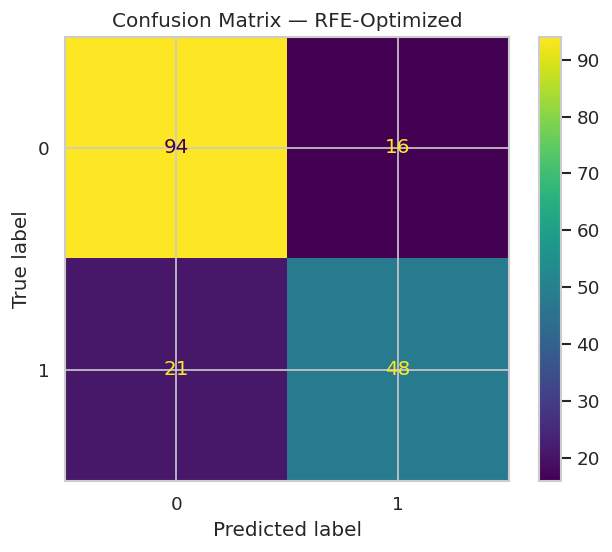

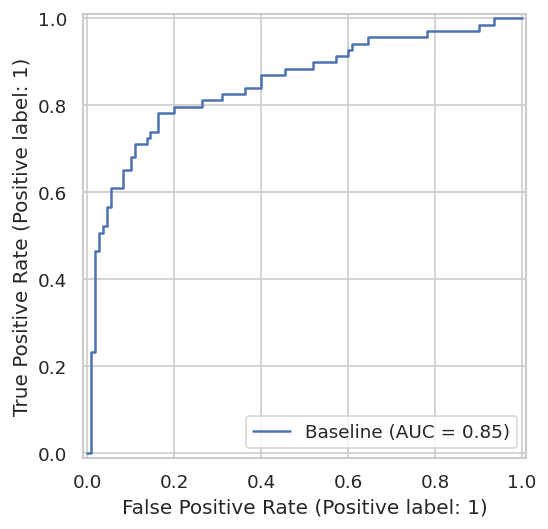

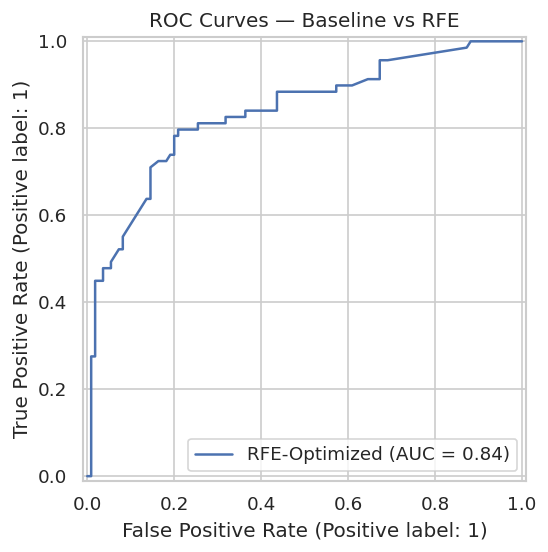

In [29]:
# Cell 10 — Train Optimized Model on Selected Features

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
)

# Reduce training/testing data to selected features only
X_train_sel = X_train_proc[:, support_mask]
X_test_sel  = X_test_proc[:, support_mask]

# Train logistic regression on selected features
clf_rfe = LogisticRegression(max_iter=1000, solver="liblinear", random_state=42)
clf_rfe.fit(X_train_sel, y_train)

# Predictions
y_pred_rfe = clf_rfe.predict(X_test_sel)
y_proba_rfe = clf_rfe.predict_proba(X_test_sel)[:, 1]

# Metrics dictionary
rfe_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_rfe),
    "Precision": precision_score(y_test, y_pred_rfe),
    "Recall": recall_score(y_test, y_pred_rfe),
    "F1": f1_score(y_test, y_pred_rfe),
    "ROC-AUC": roc_auc_score(y_test, y_proba_rfe),
}

print("RFE-Optimized Model Metrics:")
for k, v in rfe_metrics.items():
    print(f"{k:10s}: {v:.4f}")

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rfe)
plt.title("Confusion Matrix — RFE-Optimized")
plt.show()

# ROC Curve: Baseline vs RFE-Optimized
RocCurveDisplay.from_predictions(y_test, y_proba_base, name="Baseline")
RocCurveDisplay.from_predictions(y_test, y_proba_rfe, name="RFE-Optimized")
plt.title("ROC Curves — Baseline vs RFE")
plt.show()


In [30]:
# Side-by-Side Comparison Table

# Baseline aur RFE dono ke metrics compare karne ke liye DataFrame
compare_df = pd.DataFrame(
    [base_metrics, rfe_metrics],
    index=["Baseline (All Features)", "RFE-Optimized (Selected Features)"]
)

print("🔎 Baseline vs RFE-Optimized Model Performance")
display(compare_df)


🔎 Baseline vs RFE-Optimized Model Performance


,Accuracy,Precision,Recall,F1,ROC-AUC
Baseline (All Features),0.804469,0.765625,0.710145,0.736842,0.851515
RFE-Optimized (Selected Features),0.793296,0.750000,0.695652,0.721805,0.837022


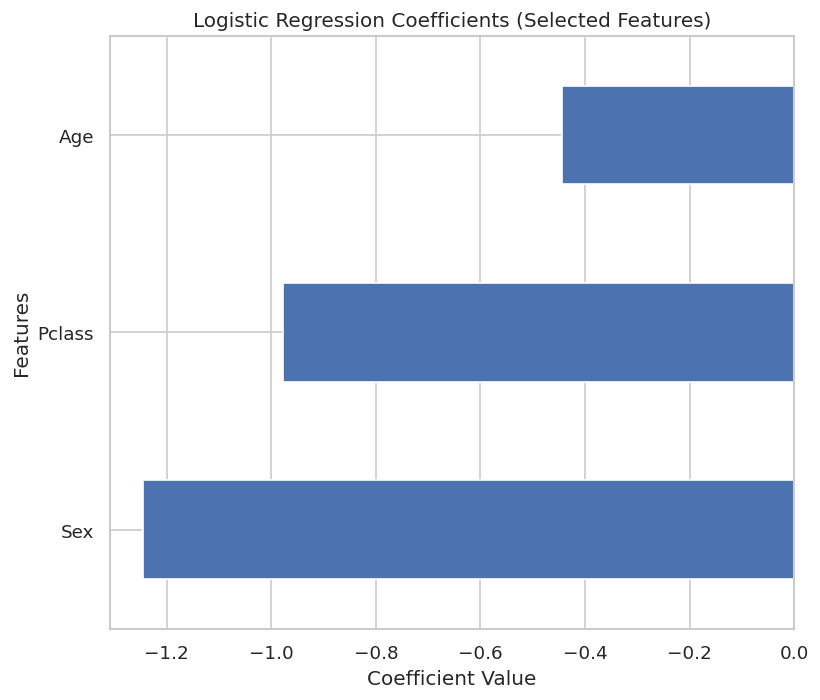

In [32]:
# Coefficients for Selected Features
# Coefficients ko series me convert karke sort karte hain
coefs = pd.Series(clf_rfe.coef_[0], index=selected_features).sort_values()

plt.figure(figsize=(7,6))
coefs.plot(kind="barh")
plt.title("Logistic Regression Coefficients (Selected Features)")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


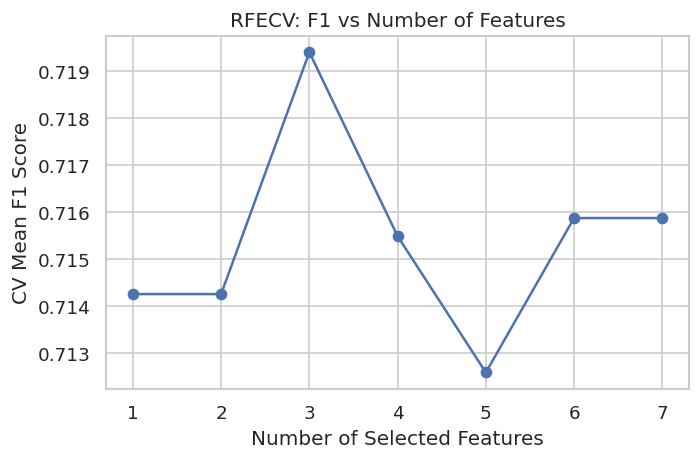

 Saved artifacts: rfe_selected_features.csv, rfecv_curve.png, baseline_vs_rfe_metrics.csv


In [33]:
# Save Artifacts (figures & selected features)

# Save selected features list
pd.Series(selected_features).to_csv("rfe_selected_features.csv", index=False)

# (Re-plot and save) RFECV curve
plt.figure(figsize=(6,4))
plt.plot(
    range(1, len(rfecv.cv_results_['mean_test_score'])+1),
    rfecv.cv_results_['mean_test_score'],
    marker="o"
)
plt.xlabel("Number of Selected Features")
plt.ylabel("CV Mean F1 Score")
plt.title("RFECV: F1 vs Number of Features")
plt.grid(True)
plt.tight_layout()
plt.savefig("rfecv_curve.png", dpi=200)
plt.show()

# Save comparison table
compare_df.to_csv("baseline_vs_rfe_metrics.csv")

print(" Saved artifacts: rfe_selected_features.csv, rfecv_curve.png, baseline_vs_rfe_metrics.csv")
